# Model of recall and cost

**Problem:** find the top-$K$ from $N$ elements (optionally in a batch of $B$ independent tasks).

**Approximate method:**
 1. Split $N$ elements into $L$ buckets (assume $L$ divides $N$), and compute the top-$J$ for each bucket (of size $N/L$).
 2. If $L\, J > K$, get the top-$K$ of these candidates.

**Metric:** _Recall_, if $S^*$ is a set of the true top-$K$ and $S$ is the set returned from our algorithm, recall $R = |S^* \cap S|/|S^*|$.

**Cost model:** (see explanation below)

 | Algorithm | Total ops (serial) | Shortest-path ops (parallel) |
 | --- | --- | --- |
 | Bubble sort / Scan-max | $B\,N(4\,K-2)$ | $K (2\log_2 N + 2)$ |
 | Radix select + filter | $B\,N(4 \log_2 N + 4)$ | $\log_2 N (2\log_2 N + 16)$ |

Therefore the cost of exact top-$K$ $C^{\mathrm{s}}(B, N, K)$ and $C^{\mathrm{p}}(B, N, K)$ are:

$C^{\mathrm{s}} = B\,N\min(4\,K-2 ,\, 4 \log_2 N + 4)$

$C^{\mathrm{p}} = \min(K (2\log_2 N + 2) ,\, \log_2 N (2\log_2 N + 16))$

And for approximate:

$C^{\mathrm{s}} = B\,N\min(4\,J-2 ,\, 4 \log_2 L + 4) + \delta(L\,J>K) B\,L\,J\min(4\,K-2 ,\, 4 \log_2 (L\,J) + 4)$

$C^{\mathrm{p}} = \min(J (2\log_2 L + 2) ,\, \log_2 L (2\log_2 L + 16)) + \delta(L\,J>K) \min(K (2\log_2 (L\,J) + 2) ,\, \log_2 (L\,J) (2\log_2 (L\,J) + 16))$


---

## Explaining the cost model

**Model:**

 - Iterating through the input data linearly is free.
 - If statements are free, but all branches are "taken".
 - Fixed-offset addressing is free.
 - Ops that count (1): `{==, <, >, &, |, not, =}`
 - Ops that count (2): `{+=, &=, |=, ^=}`

**Bubble sort (serial)**

```python
# Bubble sort (unrolled)
for i, x in data:
    if x > topk[0]:                 # +1
        topk[0] = (x, i)            # +1
    if topk[0] > topk[1]:           # +1
        swap(topk[0], topk[1])      # +3
    ...
    if topk[k-2] > topk[k-1]:       # +1
        swap(topk[k-2], topk[k-1])  # +3
```

**Scan-topk (parallel)**

```python
for i in range(k):
    j = scan_argmax(data)        # +2*log2(N)
    topk[i] = (data[j], j)       # +1
    data[j] = -inf               # +1
```

**Radix select (serial)**

```python
# Radix select (base 2)
partition = 0
partition_mask = 0
count_left = 0
for r in range(log(N)-1, -1, -1):  # log(N) bits required to find partition
    count_1 = 0
    mask = 1 << r                            # +1
    partition |= mask                        # +2
    partition_mask |= mask                   # +2
    for i, x in data:
        if x & partition_mask == partition:  # +2
            count_1 += 1                     # +2
    
    count_0 = N - count_1                    # +1
    if K < count_left + count_0:             # +2
        partition ^= mask                    # +2
    else:
        count_left += count_0                # +2

# - scan (second scan may be needed for ties)
ptr = 0
for i, x in data:
    if x > partition:      # +1
        out[ptr] = (x, i)  # +1
        ptr += 1           # +2
```

**Radix select (parallel)**

```python
# (See serial version above)
# log(N)*
#  +2 test partition & bit
#  +2*log(N) sum
#  +12 update partition
# 2*log(N) cumsum
```

---

## Tests (WIP)

In [219]:
from collections import Counter
from math import log2
import random
import scipy.stats
import pandas as pd
from typing import Any, Iterable
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from functools import lru_cache
matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})


@lru_cache(maxsize=2**24)
def binom_cdf(k: int, n: int, p: float) -> float:
    return scipy.stats.binom.cdf(k, n, p)


def recall_model(K: int, L: int, J: int) -> float:
    return (J + sum([binom_cdf(J-1, i, p=1/L) for i in range(J, K)])) / K


def recall_simulation(K: int, L: int, J: int, reps: int) -> float:
    recalls = []
    for _ in range(reps):
        counts = Counter(random.randint(0, L-1) for _ in range(K))
        recalls.append(sum(min(v, J) for v in counts.values()) / K)
    return sum(recalls) / len(recalls)


class costs:
    @staticmethod
    def serial_bubble(K: int, N: int, B: int) -> int:
        return B * N * (4*K - 2)

    @staticmethod
    def serial_radix(K: int, N: int, B: int) -> int:
        return B * N * (4*log2(N) + 4)

    @staticmethod
    def parallel_scan(K: int, N: int, B: int) -> int:
        return K * (2*log2(N) + 2)

    @staticmethod
    def parallel_radix(K: int, N: int, B: int) -> int:
        return log2(N) * (2*log2(N) + 16)

    @staticmethod
    def serial_topk(K: int, N: int, B: int) -> int:
        return min(costs.serial_bubble(K=K, N=N, B=B), costs.serial_radix(K=K, N=N, B=B))

    @staticmethod
    def parallel_topk(K: int, N: int, B: int) -> int:
        return min(costs.parallel_scan(K=K, N=N, B=B), costs.parallel_radix(K=K, N=N, B=B))

    @staticmethod
    def serial_approx_topk(K: int, N: int, B: int, L: int, J: int) -> int:
        return costs.serial_topk(K=J, N=(N//L), B=B*L) + (J*L>K) * costs.serial_topk(K=K, N=J*L, B=B)

    @staticmethod
    def parallel_approx_topk(K: int, N: int, B: int, L: int, J: int) -> int:
        return costs.parallel_topk(K=J, N=(N//L), B=B*L) + (J*L>K) * costs.parallel_topk(K=K, N=J*L, B=B)

In [226]:
def _analyse(N: int, K: int, B: int) -> Iterable[dict[str, Any]]:
    yield dict(
        algorithm="exact",
        recall=1.0,
        cost_s=costs.serial_topk(K=K, N=N, B=B),
        cost_p=costs.parallel_topk(K=K, N=N, B=B),
    )
    for L in [2**i for i in range(1, int(log2(N)) + 1)]:
        for J in [2**i for i in range(0, int(log2(K)) + 1)]:
            if L * J >= K and (J < N//L):
                yield dict(
                    algorithm="approx",
                    L=L,
                    J=J,
                    recall=recall_model(K=K, L=L, J=J),
                    cost_s=costs.serial_approx_topk(K=K, N=N, B=B, L=L, J=J),
                    cost_p=costs.parallel_approx_topk(K=K, N=N, B=B, L=L, J=J),
                )

df = pd.DataFrame.from_records(
    dict(N=N, K=K, B=B, **m)
    for N in [2**i for i in range(10, 20)][:6]
    for K in [2**i for i in range(0, int(log2(N)))]
    for B in [1]
    for m in _analyse(N=N, K=K, B=B)
)

# N, K = 2**20, 1024
# N, K = 16384, 1024
# print("      exact ", cost.serial_topk(K=K, N=N, B=1)/N)
# print("   ours J=2 ", cost.serial_approx_topk(K=K, N=N, L=K//2, J=2, B=1)/N)
# print("theirs L=2K ", cost.serial_approx_topk(K=K, N=N, L=2*K, J=1, B=1)/N)

print(len(df))
df.head()

2565


,N,K,B,algorithm,recall,cost_s,cost_p,L,J
0,1024,1,1,exact,1.0,2048.0,22.0,NaN,NaN
1,1024,1,1,approx,1.0,2052.0,24.0,2.0,1.0
2,1024,1,1,approx,1.0,2056.0,24.0,4.0,1.0
3,1024,1,1,approx,1.0,2064.0,24.0,8.0,1.0
4,1024,1,1,approx,1.0,2080.0,24.0,16.0,1.0


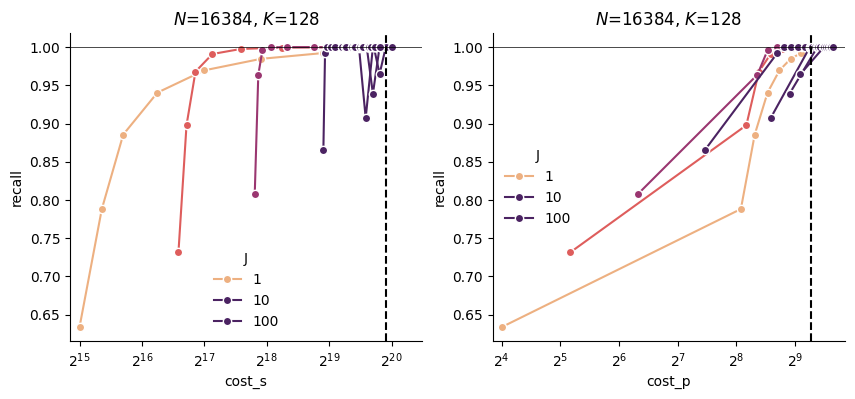

In [234]:
N, K = 16384, 128
_, axs = plt.subplots(ncols=2, figsize=(10, 4))
for cost, ax in zip(["cost_s", "cost_p"], axs):
    d = df[(df.N==N) & (df.K==K)]
    exact_cost = float(d[d.algorithm=="exact"][cost].iloc[0])
    sns.lineplot(data=d, y="recall", x=cost, hue="J", hue_norm=matplotlib.colors.LogNorm(vmax=8),
                 palette="flare", markers=True, marker="o", markeredgewidth=1, ax=ax)
    ax.axvline([exact_cost], color="k", ls="--")
    ax.axhline([1.0], color="k", lw=.5)
    ax.set_xlim((d[cost].min() * .9, exact_cost * 1.5))
    ax.set_xscale("log", base=2)
    ax.set_title(f"$N$={N}, $K$={K}")

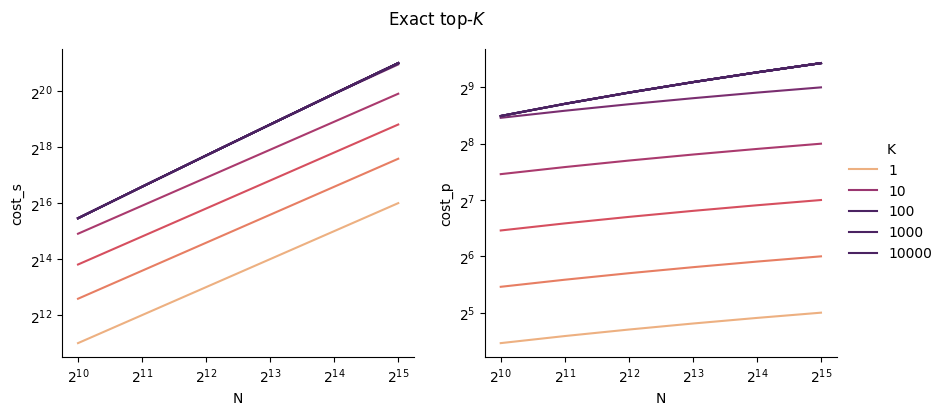

In [233]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
for y, ax in zip(["cost_s", "cost_p"], axs):
    sns.lineplot(data=df[df.algorithm=="exact"], y=y, x="N", hue="K", hue_norm=matplotlib.colors.LogNorm(vmax=32), palette="flare", ax=ax)
for ax in axs:
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.legend_.remove()
fig.legend(*axs[0].get_legend_handles_labels(), title="K", loc="center left", bbox_to_anchor=(.9, 0.5));
fig.suptitle("Exact top-$K$");